# Introduction

The purpose of this analysis is to answer 3 questions:

1. What is the tradeoff between model accuracy and the size of the training data set?
2. What is the tradeoff between model accuracy and the number of sensors used?
3. Does the accuracy of the sensors change over time?

Now we could argue that there is an additional question in regards to the interaction effect between the training size and the number of sensors. We can explore that question as well if time allows. So, now comes the most important question

__Why do we care about these questions?__  

The reason we care about the first question is because experimentation can be laborious and time consuming. We want to be able to start accurately predicting the chemicals to save precious time that could be better spent on something besides testing.

The reason we care about the second question is because the more sensors required in equipment using these sensors for processing the more expensive it will be.

The reason we care about third questions is because like everything phyisical in life, the sensors have a quantifiable usable life. Eventually, they will break down and no longer function. However, before the sensor completely fails, it will experience a decrease in performance at some unknown rate, typically known as drift. We would like to determine if there is any indication of drift occuring.

# Import Packages & Data

## Import Packages

In [132]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

## Import Data

In [3]:
#Get the relative local folder where the data is stored
base_fpath = os.getcwd() #the file path to the working directory of the code
d_path = base_fpath.replace('notebooks', 'data') #raw data file path

s_data = pd.read_csv(d_path + '/gas_data_cleaned.csv') #sensor data

# Scale Data & Feature Reduction/Selection

## Split the Data

In [37]:
ind_vars = s_data.drop(columns=['ChemicalCode', 'Concentration', 'BatchNumber']).columns #column names of the independent variables
tt_data = s_data[s_data['BatchNumber'] <= 5] #train test dataset
X_tt = tt_data[ind_vars] #train test independent variable dataset
y_tt_code = tt_data['ChemicalCode'] #1st dependent variable
y_tt_con = tt_data['Concentration'] #2nd dependent variable

test_size = .3
X_train, X_test, y_code_train, y_code_test = train_test_split(X_tt, y_tt_code, test_size=test_size, random_state=1991, stratify=y_tt_code) #split the data 1st time
X_train, X_test, y_con_train, y_con_test = train_test_split(X_tt, y_tt_con, test_size=test_size, random_state=1991, stratify=y_tt_code) #split the data for the second dependent variable, should be the same

f_data = s_data[s_data['BatchNumber'] > 5] #future dataset
X_f = f_data[ind_vars] #train test independent variable dataset
y_f_code = f_data['ChemicalCode'] #1st dependent variable
y_f_con = f_data['Concentration'] #2nd dependent variable

## Scale the Data

In [38]:
ss = StandardScaler().fit(X_train)
X_train_s = pd.DataFrame(ss.transform(X_train), columns=ind_vars)
X_test_s = pd.DataFrame(ss.transform(X_test), columns=ind_vars)
X_f_s = pd.DataFrame(ss.transform(X_f), columns=ind_vars)

## Feature Reduction/Selection

### High Correlation Method

In [15]:
X_corr_train = pd.read_csv(d_path + '/CorrelationMethod/train.csv')
X_corr_test = pd.read_csv(d_path + '/CorrelationMethod/test.csv')
X_corr_f = pd.read_csv(d_path + '/CorrelationMethod/future.csv')

# Classification of Chemical Species

## Baseline Model Creation

              precision    recall  f1-score   support

           1       0.22      0.17      0.19       213
           2       0.28      0.19      0.23       302
           3       0.13      0.17      0.15       129
           4       0.08      0.11      0.09       136
           5       0.24      0.16      0.19       286
           6       0.01      0.08      0.02        24

    accuracy                           0.16      1090
   macro avg       0.16      0.15      0.15      1090
weighted avg       0.21      0.16      0.18      1090



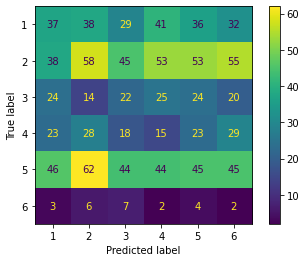

In [46]:
# Randomly Choose a Chemical Species
dc_rand = DummyClassifier(strategy = 'uniform', random_state=1991) #create a model that randomly chooses chemicals
dc_rand.fit(X_corr_train, y_code_train)
dc_rand.score(X_corr_train, y_code_train)
print(classification_report(y_code_test, dc_rand.predict(X_corr_test)))

ConfusionMatrixDisplay(confusion_matrix(y_code_test, dc_rand.predict(X_corr_test)), display_labels=dc_rand.classes_).plot() #display the confusion matrix
plt.show()

Using a random method we would expect the accuracy to be approximately 1 in 6 chance, 16.7%, of guessing the correct number. In this case we had a model accuracy of 16%, so near theoretical. We could also create a model based on the most frequent chemical or account for the distribution of the chemicals tested.

In [47]:
# Always Choose the Most Frequent Chemical Species
dc_rand = DummyClassifier(strategy = 'most_frequent', random_state=1991) #create a model that chooses the most frequent chemical code in the training set
dc_rand.fit(X_corr_train, y_code_train)
dc_rand.score(X_corr_train, y_code_train)
print(classification_report(y_code_test, dc_rand.predict(X_corr_test)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       213
           2       0.28      1.00      0.43       302
           3       0.00      0.00      0.00       129
           4       0.00      0.00      0.00       136
           5       0.00      0.00      0.00       286
           6       0.00      0.00      0.00        24

    accuracy                           0.28      1090
   macro avg       0.05      0.17      0.07      1090
weighted avg       0.08      0.28      0.12      1090



C:\Users\sscov\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In this case our accuracy is 28%, which is the heighest we've seen so far and we can use this model for our baseline performance.

## Intermediate Model Creation

### Classification Tree

In [74]:
# Model Creation
dt_corr = DecisionTreeClassifier()
dt_corr.fit(X_corr_train, y_code_train)

print('The full model has a depth of {} and has {} leaves'.format(dt.get_depth(), dt.get_n_leaves()))
print('\n')
print(classification_report(y_code_test, dt.predict(X_corr_test)))

The full model has a depth of 34 and has 1082 leaves


              precision    recall  f1-score   support

           1       0.18      0.17      0.17       213
           2       0.28      0.28      0.28       302
           3       0.15      0.16      0.15       129
           4       0.15      0.18      0.16       136
           5       0.26      0.24      0.25       286
           6       0.05      0.04      0.04        24

    accuracy                           0.22      1090
   macro avg       0.18      0.18      0.18      1090
weighted avg       0.22      0.22      0.22      1090



Based on the number of leaves and depth we can already tell that this model is huge and extremely over fit to the training data. Also when we look at the model accuracy we see that it actually scored less than our most frequent dummy classifier that we created above. In other words we created a very complex model and obtained results worse than guessing a single value. However, lets quickly look at the decision tree to help us get a sense of scale of just how big the tree is.

In [67]:
# Tree Visualization
from IPython.display import Image 
_ = plt.figure(figsize = (15,10))
dot_data = export_graphviz(dt_corr, out_file=None, filled=True, rounded=True, feature_names=X_corr_train.columns, impurity=False, class_names=str(dt_corr.classes_))

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render()
#display(graph)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.512168 to fit


'Source.gv.png'

<Figure size 1080x720 with 0 Axes>

The graph was way too large to have it inline, so here is the imported picture of the tree. We can see that the tree is extremely wide compared to how deep it is as it fits each element perfectly. Let's now trim the tree by specifiying a maximum depth.
![alt text](Source.png "Full Classification Tree")

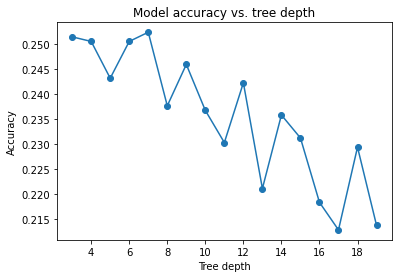

In [84]:
#Tree Depth Selection
depth_scores = [] #list to capture the accuracy based on tree depth

for d in range(3, 20):
    dt = DecisionTreeClassifier(max_depth=d, random_state=1991) #create a model with the specified maximum tree depth
    dt.fit(X_corr_train, y_code_train) #use the correlation data set
    depth_scores.append(dt.score(X_corr_test, y_code_test)) #update the score list

plt.plot(range(3,20), depth_scores, marker='o')
plt.title('Model accuracy vs. tree depth')
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')

plt.show()

For the most part the model accuracy seems to linearly decrease with respect to the tree depth, with no distinct elbow. Let's also try controlling the maximum number of leaves.

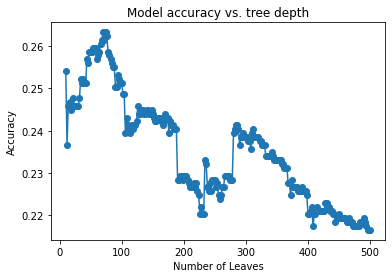

In [85]:
#Tree Depth Selection
leaf_scores = [] #list to captue the accurcy based on the number of leaves

for l in range(10, 501, 2):
    dt = DecisionTreeClassifier(max_leaf_nodes=l, random_state=1991) #create a model with the specified amount of leaves
    dt.fit(X_corr_train, y_code_train) #use the correlation data set
    leaf_scores.append(dt.score(X_corr_test, y_code_test)) #update the score list

plt.plot(range(10,501, 2), leaf_scores, marker='o')
plt.title('Model accuracy vs. tree depth')
plt.xlabel('Number of Leaves')
plt.ylabel('Accuracy')

plt.show()

although we can see a trend or peak value in each of the tradeoffs developed we still do not have better model accuracy than our basic model. This could either be the result of the correlation method we chose to use for the feature selection or we need to choose a better modeling method. Let's try working with the entire feature set first with a simple model and see if we can get better accuracy than our baseline.

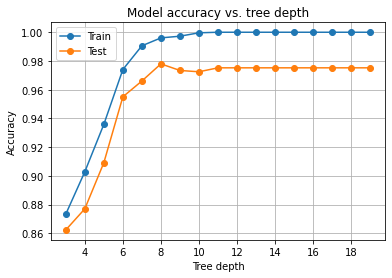

In [109]:
depth_scores = [] #list to capture the accuracy based on the maximum tree depth

for d in range(3, 20):
    dt = DecisionTreeClassifier(max_depth=d, random_state=1991) #create a model with the specified maximum tree depth
    dt.fit(X_train, y_code_train) #use the full feature data set
    depth_scores.append([dt.score(X_train, y_code_train),dt.score(X_test, y_code_test)]) #update the score list

plt.plot(range(3,20), depth_scores, marker='o')
plt.title('Model accuracy vs. tree depth')
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.legend(labels=['Train','Test'])
plt.grid(True)

plt.show()

The graph above looks a lot more like we would expect. At the very begining it is encouraging to see that even with a single layer tree depth we get an accuracy of 86% on our test data. From there, the accuracy steadily increases as we move away from underfitting, until it peaks out at a depth of 8. Then it it takes a dip as we start to overfit our training dataset. At a depth of approximately 11 we see the accuracy taper off sugesting that the full tree most does not require a depth gerater than 11 to fit all of the data points. To make sure we are not missing out on any of the individual classes, lets look at the classification report using a tree depth of 8.

In [88]:
dt = DecisionTreeClassifier(max_depth=8, random_state=1991)
dt.fit(X_train, y_code_train)

print('The full model has a depth of {} and has {} leaves'.format(dt.get_depth(), dt.get_n_leaves()))
print('\n')
print(classification_report(y_code_test, dt.predict(X_test)))

The full model has a depth of 8 and has 55 leaves


              precision    recall  f1-score   support

           1       0.98      0.96      0.97       213
           2       0.99      1.00      0.99       302
           3       0.96      0.98      0.97       129
           4       0.96      0.93      0.95       136
           5       0.98      0.99      0.99       286
           6       1.00      0.96      0.98        24

    accuracy                           0.98      1090
   macro avg       0.98      0.97      0.97      1090
weighted avg       0.98      0.98      0.98      1090



So although we are now using the full feature set, our model can obtain 98% accuracy on the test data, well above our baseline, with only 55 leaves and a tree depth of 8. This indicates to me that the correlation feature set is not well suited for predicting the chemical being processed. Let's look at the importance of each feature in this prediction and look how it differs from our correlation feature set.

In [118]:
fi = dt.feature_importances_
dt_feats = X_train.columns[fi > 0].tolist()
dt_feats = pd.DataFrame([dt_feats, fi[fi > 0]], index=['Variable', 'Importance'])
dt_feats = dt_feats.T
dt_feats.sort_values('Importance', ascending=False)

,Variable,Importance
3,EMAd0.001_1,0.259254
7,EMAd0.1_2,0.225337
17,|DR|_7,0.156137
25,|DR|_10,0.090562
39,EMAi0.1_13,0.045117
21,|DR|_9,0.031711
0,DR_1,0.031325
10,DR_4,0.023777
29,EMAi0.01_11,0.017797
14,|DR|_6,0.016492


In [107]:
common_feats = [f for f in X_corr_train.columns.tolist() if f in X_train.columns[fi>0].tolist()] #features that are common between the correlation dataset and the decision tree dataset
print(common_feats)

['DR_1', 'EMAd0.01_4', 'EMAi0.01_5', 'EMAd0.01_5', 'EMAd0.01_6']


So this basic classification model has determined that only 38 features, out of the 128 we started with, have any importance whatsoever in predicting which chemical is being processed. Also out of those 38 important features, we only selected five of the features using our correlation method, four of which have a significance value less than 0.01. Let's now try some more advanced models using the features with a significance level greater than 0.01 from this basic decision tree.

## Grid Search & Cross Fold 

In [127]:
# Create a new data subset using the important features in the basic decision tree model
tree_feats = dt_feats[dt_feats['Importance'] > 0.01].Variable.tolist()
X_tree_train = X_train[tree_feats]
X_tree_test = X_test[tree_feats]
X_tree_f = X_test[tree_feats]

In [134]:
param_grid = [{'classifier__max_depth': [2,3,4,5,6,7,8]}]
steps = [('classifier', DecisionTreeClassifier(random_state=1991))]
class_pipe = Pipeline(steps=steps)
grid = GridSearchCV(class_pipe, param_grid, cv=5, verbose=1,n_jobs=-1)
grid.fit(X_tree_train, y_code_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    5.5s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier(random_state=1991))]),
             n_jobs=-1,
             param_grid=[{'classifier__max_depth': [2, 3, 4, 5, 6, 7, 8]}],
             verbose=1)

In [136]:
print(grid.best_params_)
print(grid.score(X_tree_test, y_code_test))

{'classifier__max_depth': 7}
0.9706422018348624


# M